In [1]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install folium


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


2019.01~06 중에 언제 지하철을 가장 많이 이용했을까? (기준: 승하차총승객수)

In [2]:
# 1. 필요한 라이브러리 불러오기

import collections
import datetime
import glob
import math
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium


pd.options.display.float_format = '{:,}'.format

plt.rcParams['font.family'] ='D2Coding'
plt.rcParams['axes.unicode_minus'] =False

DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']

In [3]:
# 2. 현재 사용가능한 데이터 확인

BASE_DIR = pathlib.Path('../').resolve()

os.listdir(BASE_DIR / '실습' / 'rawfiles')

['CARD_SUBWAY_MONTH_201903.csv',
 'CARD_SUBWAY_MONTH_201902.csv',
 'CARD_SUBWAY_MONTH_201901.csv',
 'CARD_SUBWAY_MONTH_201905.csv',
 'CARD_SUBWAY_MONTH_201904.csv',
 'CARD_SUBWAY_MONTH_201906.csv',
 '지하철노선위경도정보2.csv']

In [5]:
# 3. 데이터를 병합하여 하나의 데이터프레임 형성

df_subway_raw = pd.DataFrame()

for filename in glob.glob(str(BASE_DIR / '실습' / 'rawfiles' / 'CARD_SUBWAY_MONTH_*.csv')):
    tmp = pd.read_csv(filename)
    df_subway_raw = pd.concat([df_subway_raw, tmp])

In [5]:
df_subway_raw.sample(5)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자
3779,20190407,1호선,백운,"6,291.0","6,336.0",20190410
3771,20190107,4호선,선바위,"10,258.0","8,113.0",20190110
16133,20190228,5호선,둔촌동,"10,023.0","10,153.0",20190303
14297,20190225,4호선,남태령,"1,641.0","1,212.0",20190228
2540,20190605,1호선,도화,"5,144.0","4,731.0",20190608


In [6]:
df_subway_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


In [7]:
# dt.dayofweek로 표현된 요일의 번호가 0~6까지 각각 월~일에 대응되는지 확인해보자.

df = df_subway_raw.copy()

df['사용일자'] = pd.to_datetime(df['사용일자'], format='%Y%m%d')
df['요일'] = df['사용일자'].dt.dayofweek

# 달력을 통해, 2019년 5월 5일 어린이날은 '일요일'인 것을 알고있는 상황.
# 2019년도 어린이 날에 해당하는 데이터만 필터링한다.
df = df[df['사용일자'] == '2019-05-05']

# 어린이 날(일요일)의 dayofweek(숫자)를 확인한다.
df.head()

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,요일
2370,2019-05-05,4호선,서울역,"45,856.0","42,422.0",20190508,6
2371,2019-05-05,2호선,시청,"15,457.0","15,413.0",20190508,6
2372,2019-05-05,1호선,종각,"31,735.0","27,154.0",20190508,6
2373,2019-05-05,3호선,종로3가,"26,047.0","24,846.0",20190508,6
2374,2019-05-05,1호선,종로5가,"16,105.0","16,292.0",20190508,6


In [8]:
df_subway_raw['사용일자'] = pd.to_datetime(df_subway_raw['사용일자'], format='%Y%m%d')
df_subway_raw['주차'] = df_subway_raw['사용일자'].dt.dayofyear // 7 + 1
df_subway_raw['요일'] = df_subway_raw['사용일자'].dt.dayofweek.map({ idx: val for idx, val in enumerate(DAY_OF_WEEK) })
df_subway_raw['연'] = df_subway_raw['사용일자'].dt.year
df_subway_raw['월'] = df_subway_raw['사용일자'].dt.month
df_subway_raw['일'] = df_subway_raw['사용일자'].dt.date
df_subway_raw['승하차총승객수'] = (df_subway_raw['승차총승객수'] + df_subway_raw['하차총승객수']).astype(int)

df_subway_raw.sample(10)

,사용일자,노선명,역명,승차총승객수,하차총승객수,등록일자,주차,요일,연,월,일,승하차총승객수
12029,2019-04-21,1호선,녹양,"3,545.0","3,318.0",20190424,16,일,2019,4,2019-04-21,6863
16866,2019-04-29,경의선,용문,"2,566.0","2,536.0",20190502,18,월,2019,4,2019-04-29,5102
4447,2019-02-08,경의선,망우,"8,492.0","8,437.0",20190211,6,금,2019,2,2019-02-08,16929
10533,2019-01-18,7호선,학동,"26,419.0","29,348.0",20190121,3,금,2019,1,2019-01-18,55767
7260,2019-01-13,1호선,백운,"5,477.0","5,481.0",20190116,2,일,2019,1,2019-01-13,10958
17118,2019-05-29,경의선,디지털미디어시티,"15,268.0","13,570.0",20190601,22,수,2019,5,2019-05-29,28838
1793,2019-01-04,2호선,신당,"16,887.0","17,581.0",20190107,1,금,2019,1,2019-01-04,34468
6046,2019-04-11,1호선,관악,"10,150.0","9,585.0",20190414,15,목,2019,4,2019-04-11,19735
4601,2019-02-08,1호선,노량진,"12,625.0","11,766.0",20190211,6,금,2019,2,2019-02-08,24391
3789,2019-02-07,분당선,미금,"18,338.0","19,461.0",20190210,6,목,2019,2,2019-02-07,37799


# 이제 문제에 답해봅시다.

### 1. 2019.01~06중에 언제 지하철을 가장 많이 이용했을까? (기준:승하차총승객수)

In [9]:
df_subway_raw.groupby('월').sum('승하차총승객수').sort_values('승하차총승객수', ascending=False)

,승차총승객수,하차총승객수,등록일자,주차,연,승하차총승객수
월,,,,,,
5,"243,338,053.0","242,380,504.0",370213478472,366705,37020384,485718557
4,"235,928,571.0","235,005,777.0",358359862392,278074,35835231,470934348
3,"233,813,277.0","232,879,549.0",370330953373,206498,37032498,466692826
1,"221,848,014.0","220,898,375.0",370165764399,52645,37016346,442746389
6,"221,547,039.0","220,663,596.0",357858646377,431295,35784756,442210635
2,"190,335,812.0","189,500,198.0",334006895930,116999,33400317,379836010


### 2. 가설) 1월~6월중에 5월에 지하철 승객수가 많다? (기준:승하차총승객수

In [10]:
df = df_subway_raw[['사용일자', '승하차총승객수', '요일']] \
    .groupby(['사용일자', '요일']) \
    .sum() \
    .reset_index() \
    .sort_values('승하차총승객수', ascending=False)

df.head(5)

,사용일자,요일,승하차총승객수
122,2019-05-03,금,18425509
129,2019-05-10,금,18297824
143,2019-05-24,금,18107448
136,2019-05-17,금,18085208
101,2019-04-12,금,17992610


In [11]:
df = df_subway_raw.groupby('월') \
    .sum(numeric_only=True) \
    .reset_index() \
    .sort_values('승하차총승객수', ascending=False)

df  # prints the dataframe

,월,승차총승객수,하차총승객수,등록일자,주차,연,승하차총승객수
4,5,"243,338,053.0","242,380,504.0",370213478472,366705,37020384,485718557
3,4,"235,928,571.0","235,005,777.0",358359862392,278074,35835231,470934348
2,3,"233,813,277.0","232,879,549.0",370330953373,206498,37032498,466692826
0,1,"221,848,014.0","220,898,375.0",370165764399,52645,37016346,442746389
5,6,"221,547,039.0","220,663,596.0",357858646377,431295,35784756,442210635
1,2,"190,335,812.0","189,500,198.0",334006895930,116999,33400317,379836010


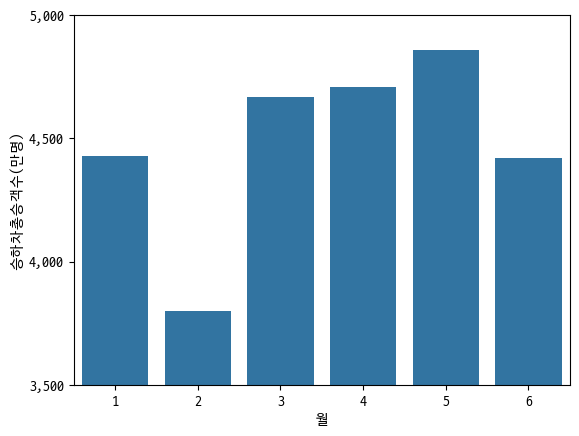

In [12]:
sns.barplot(data=df, x='월', y='승하차총승객수')
plt.ylabel('승하차총승객수(만명)')
plt.ylim(35e7, 50e7)
plt.yticks([35e7, 40e7, 45e7, 50e7], ['3,500', '4,000', '4,500', '5,000'])
plt.show()

In [13]:
row = df.iloc[0]
print(f'{row['월']:.0f}월에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명')

5월에 가장 많은 승객수 485,718,557명


### 3. 가설) 요일중에서 목요일에 지하철 승객수가 많다? (기준:승하차총승객수)

In [14]:
df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .sum(numeric_only=True) \
    .reset_index()

# 가장 많은 승객수를 가진 요일을 찾아보자.
df.iloc[df['승하차총승객수'].idxmax()]

요일                 금
승하차총승객수    445310717
Name: 0, dtype: object

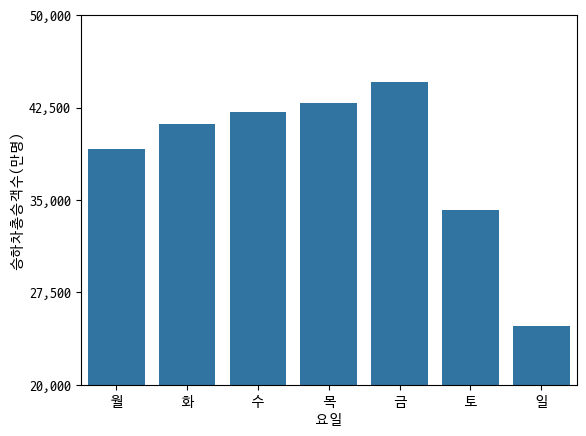

In [15]:
sns.barplot(data=df, x='요일', y='승하차총승객수', order=DAY_OF_WEEK)

max_y = 5e8
yticks = np.linspace(0.4 * max_y, max_y, 5)
ylabels = [f'{int(val)//int(1e4):,}' for val in yticks]

plt.ylim(yticks[0], yticks[-1])
plt.yticks(ticks=yticks, labels=ylabels)
plt.ylabel('승하차총승객수(만명)')
plt.show()

In [16]:
df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .mean(numeric_only=True) \
    .reset_index()
df.sort_values(by='승하차총승객수', ascending=False).head()

,요일,승하차총승객수
0,금,"28,959.531573128697"
1,목,"27,869.222662852684"
2,수,"27,397.966039945353"
6,화,"26,784.99219816657"
3,월,"26,474.344219066938"


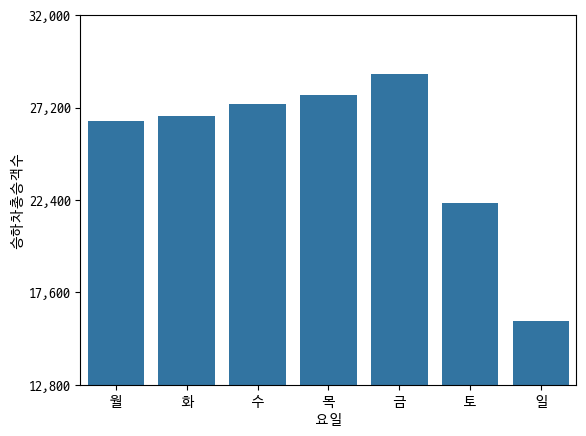

In [17]:
sns.barplot(data=df, x='요일', y='승하차총승객수', order=['월', '화', '수', '목', '금', '토', '일'])

max_y = 3.2e4
yticks = np.linspace(0.4 * max_y, max_y, 5)
ylabels = [f'{int(val):,}' for val in yticks]

plt.ylim(yticks[0], yticks[-1])
plt.yticks(ticks=yticks, labels=ylabels)
plt.show()

합계와 평균을 한 Plot 에 넣어서 비교해보자.

In [18]:
palette = sns.color_palette('husl', n_colors=7)
palette

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7757319041862729, 0.5784925270759935, 0.19475566538551875),
 (0.5105309046900421, 0.6614299289084904, 0.1930849118538962),
 (0.20433460114757862, 0.6863857739476534, 0.5407103379425205),
 (0.21662978923073606, 0.6676586160122123, 0.7318695594345369),
 (0.5049017849530067, 0.5909119231215284, 0.9584657252128558),
 (0.9587050080494409, 0.3662259565791742, 0.9231469575614251)]

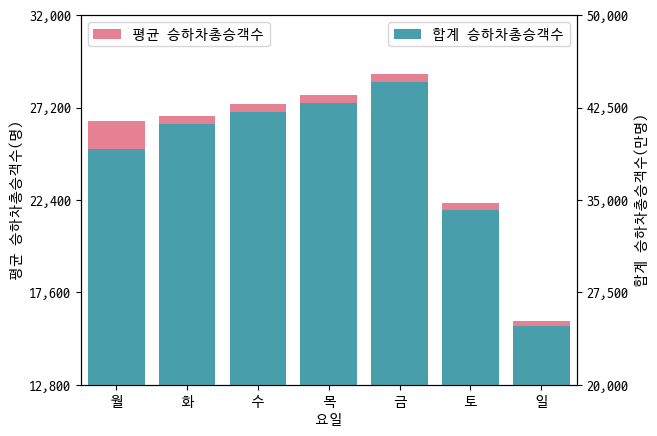

In [19]:
common_kwargs = {
    'x': '요일',
    'y': '승하차총승객수',
    'order': DAY_OF_WEEK,
}

# Average

color = palette[0]
max_y = 3.2e4

fig, ax = plt.subplots()

df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .mean(numeric_only=True) \
    .reset_index()

yticks = np.linspace(0.4 * max_y, max_y, 5)
ylabels = [f'{int(val):,}' for val in yticks]

sns.barplot(data=df, ax=ax, color=color, label='평균 승하차총승객수', **common_kwargs)

ax.set_ylim(yticks[0], yticks[-1])
ax.set_yticks(ticks=yticks, labels=ylabels)
ax.set_ylabel('평균 승하차총승객수(명)')
ax.legend(loc='upper left')

# Sum

color = palette[4]
max_y = 5e8

ax = ax.twinx()  # 두 번째 y축을 만들기 위해 twinx()를 사용한다.

df = df_subway_raw[['요일', '승하차총승객수']] \
    .groupby('요일') \
    .sum(numeric_only=True) \
    .reset_index()
yticks = np.linspace(0.4 * max_y, max_y, 5)
ylabels = [f'{int(val)//int(1e4):,}' for val in yticks]

sns.barplot(data=df, ax=ax, color=color, label='합계 승하차총승객수', **common_kwargs)

ax.set_ylim(yticks[0], yticks[-1])
ax.set_yticks(ticks=yticks, labels=ylabels)
ax.set_ylabel('합계 승하차총승객수(만명)')
ax.legend(loc='upper right')

plt.show()

In [20]:
df = df_subway_raw[['요일', '승하차총승객수']]
df.sort_values(by='승하차총승객수', ascending=False).head()

,요일,승하차총승객수
5943,금,270553
14224,금,268590
10085,금,267565
8295,금,265482
1809,금,264826


In [21]:
row = df.sort_values(by='승하차총승객수', ascending=False).iloc[0]
print(f"{row['요일']}요일에 가장 많은 승객수 {row['승하차총승객수']:,.0f}명")

금요일에 가장 많은 승객수 270,553명


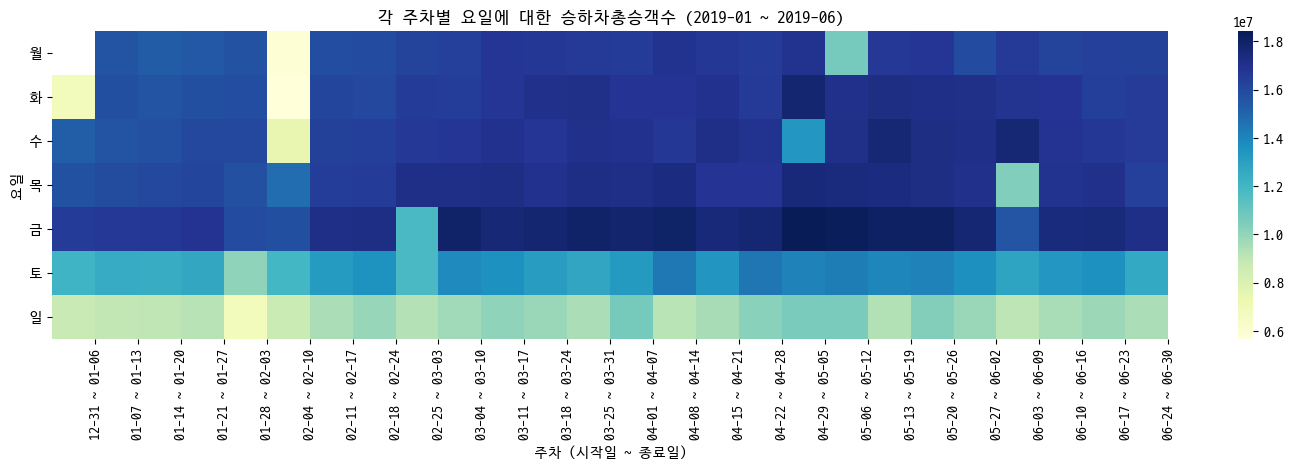

In [22]:
df = df_subway_raw \
    .groupby(['주차', '요일']) \
    .sum(numeric_only=True) \
    .reset_index() \
    .pivot(index='요일', columns='주차', values='승하차총승객수')

df.index = pd.CategoricalIndex(df.index, categories=DAY_OF_WEEK)
df.sort_index(inplace=True)

date = datetime.date(2018, 12, 31)
xticks = []
xlabels = []
for i in range(1, 27):
    xticks.append(i)
    xlabels.append(f'{date:%m-%d} ~ {date + datetime.timedelta(days=6):%m-%d}')
    date += datetime.timedelta(weeks=1)

plt.figure(figsize=(18, 4))
sns.heatmap(df, cmap='YlGnBu')
plt.title("각 주차별 요일에 대한 승하차총승객수 (2019-01 ~ 2019-06)")
plt.yticks(rotation=0)
plt.xticks(ticks=xticks, labels=xlabels, rotation=90)
plt.xlabel('주차 (시작일 ~ 종료일)')
plt.show()

In [23]:
# 혹시 특정 월에 휴일이 몰려있는게 영향이 있을까?

holidays = [
    datetime.date(2019, 1, 1),  # 신정
    datetime.date(2019, 2, 4),  # 설날(연휴)
    datetime.date(2019, 2, 5),  # 설날
    datetime.date(2019, 2, 6),  # 설날(연휴)
    datetime.date(2019, 3, 1),  # 삼일절
    datetime.date(2019, 5, 5),  # 어린이날
    datetime.date(2019, 5, 6),  # (어린이날)대체휴일
    datetime.date(2019, 5, 12),  # 부처님오신날
    datetime.date(2019, 6, 6),  # 현충일
    datetime.date(2019, 8, 15),  # 광복절
    datetime.date(2019, 9, 12),  # 추석(연휴)
    datetime.date(2019, 9, 13),  # 추석
    datetime.date(2019, 9, 14),  # 추석(연휴)
    datetime.date(2019, 10, 3),  # 개천절
    datetime.date(2019, 10, 9),  # 한글날
    datetime.date(2019, 12, 25),  # 크리스마스
]

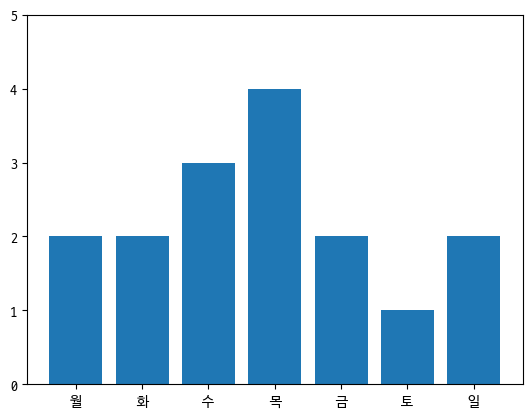

In [24]:
holidays_per_dayofweek = collections.Counter()
for holiday in holidays:
    holidays_per_dayofweek[DAY_OF_WEEK[holiday.weekday()]] += 1

plt.bar(x=DAY_OF_WEEK, height=[holidays_per_dayofweek[dow] for dow in DAY_OF_WEEK])
plt.yticks(range(0, 6))
plt.show()

In [25]:
df = df_subway_raw \
    .groupby(['사용일자', '요일']) \
    .sum(numeric_only=True) \
    .reset_index()

df.index = pd.CategoricalIndex(df.index, categories=DAY_OF_WEEK)
df.sort_index(inplace=True)

df  # prints the dataframe

,사용일자,요일,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
NaN,2019-01-01,화,"3,419,948.0","3,393,505.0",11952541568,592,1195248,592,6813453
NaN,2019-01-02,수,"7,621,668.0","7,592,334.0",11952542160,592,1195248,592,15214002
NaN,2019-01-03,목,"7,873,692.0","7,842,521.0",11972732858,593,1197267,593,15716213
NaN,2019-01-04,금,"8,270,345.0","8,238,936.0",11912163130,590,1191210,590,16509281
NaN,2019-01-05,토,"6,062,294.0","6,030,041.0",11891973612,589,1189191,589,12092335
...,...,...,...,...,...,...,...,...,...
NaN,2019-06-26,수,"8,295,254.0","8,266,536.0",11973042997,15418,1197267,3558,16561790
NaN,2019-06-27,목,"8,197,084.0","8,168,560.0",11952852960,15392,1195248,3552,16365644
NaN,2019-06-28,금,"8,599,857.0","8,570,855.0",11932704291,15366,1193229,3546,17170712
NaN,2019-06-29,토,"6,316,617.0","6,284,920.0",11912514180,15340,1191210,3540,12601537


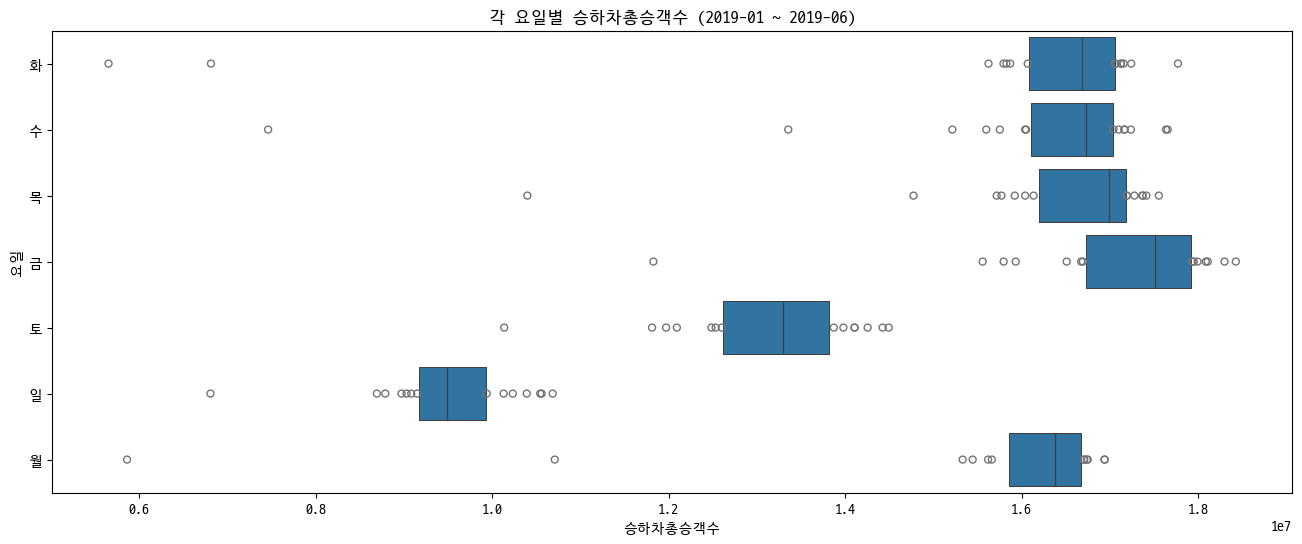

In [26]:
plt.figure(figsize=(16, 6))
sns.boxenplot(data=df, x='승하차총승객수', y='요일')
plt.title("각 요일별 승하차총승객수 (2019-01 ~ 2019-06)")
plt.show()

### 4. 연월 각각에 대해 일자별(월일별) 승하차총승객수 그래프 그려 볼까요? (pointplot)

In [27]:
df = df_subway_raw \
    .groupby('사용일자') \
    .sum(numeric_only=True) \
    .reset_index()
df['월'] = df['사용일자'].dt.month
df['일'] = df['사용일자'].dt.day
df['요일'] = df['사용일자'].dt.dayofweek
df # prints the dataframe

,사용일자,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수,일,요일
0,2019-01-01,"3,419,948.0","3,393,505.0",11952541568,592,1195248,1,6813453,1,1
1,2019-01-02,"7,621,668.0","7,592,334.0",11952542160,592,1195248,1,15214002,2,2
2,2019-01-03,"7,873,692.0","7,842,521.0",11972732858,593,1197267,1,15716213,3,3
3,2019-01-04,"8,270,345.0","8,238,936.0",11912163130,590,1191210,1,16509281,4,4
4,2019-01-05,"6,062,294.0","6,030,041.0",11891973612,589,1189191,1,12092335,5,5
...,...,...,...,...,...,...,...,...,...,...
176,2019-06-26,"8,295,254.0","8,266,536.0",11973042997,15418,1197267,6,16561790,26,2
177,2019-06-27,"8,197,084.0","8,168,560.0",11952852960,15392,1195248,6,16365644,27,3
178,2019-06-28,"8,599,857.0","8,570,855.0",11932704291,15366,1193229,6,17170712,28,4
179,2019-06-29,"6,316,617.0","6,284,920.0",11912514180,15340,1191210,6,12601537,29,5


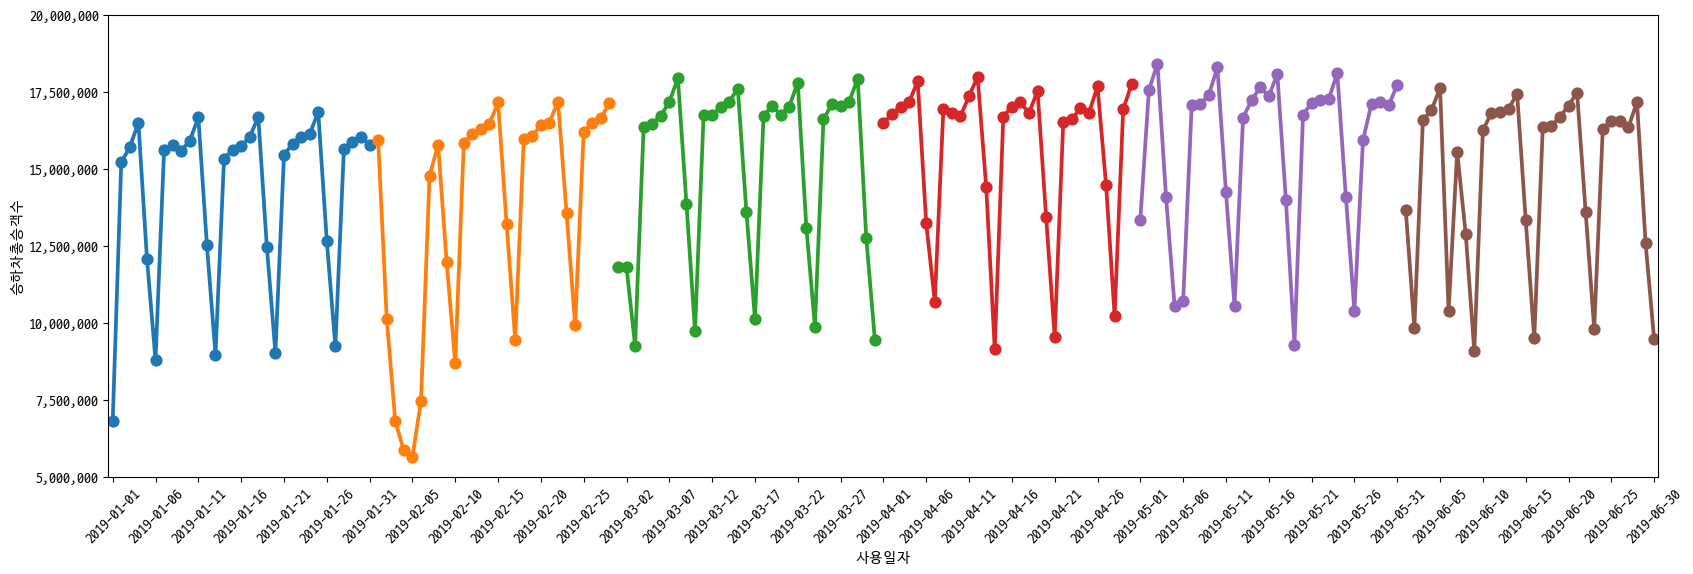

In [28]:
plt.figure(figsize=(20, 6))
for month in range(1, 6+1):
    sns.pointplot(data=df[df['월'] == month], x='사용일자', y='승하차총승객수')
plt.yticks(np.linspace(0.5e7, 2e7, 7), map(lambda x: f'{int(x):,}', np.linspace(0.5e7, 2e7, 7)))
plt.xticks(plt.xticks()[0][::5], rotation=45)
plt.show()

### 5. 가장 승객이 많이 타는 승차역은?

잠실역이 가장 많은 승객수 18,574,323명


,역명,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
413,잠실,"18,574,323.0","18,390,074.0",7308916248,4912,730878,1270,36964397


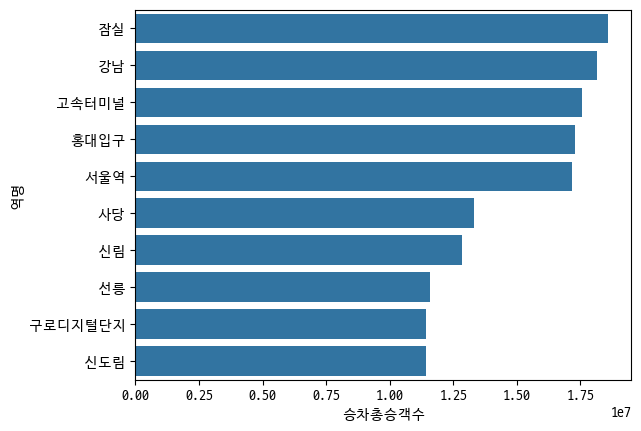

In [29]:
df = df_subway_raw.groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

row = df[['역명', '승차총승객수']].iloc[0]
print(f'{row["역명"]}역이 가장 많은 승객수 {row["승차총승객수"]:,.0f}명')

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

df.head(1)

### 6. 노선별로 역별/요일별 승차승객수를 비교해 볼수 있을까? (1~9호선, 역별/요일별 heatmap)

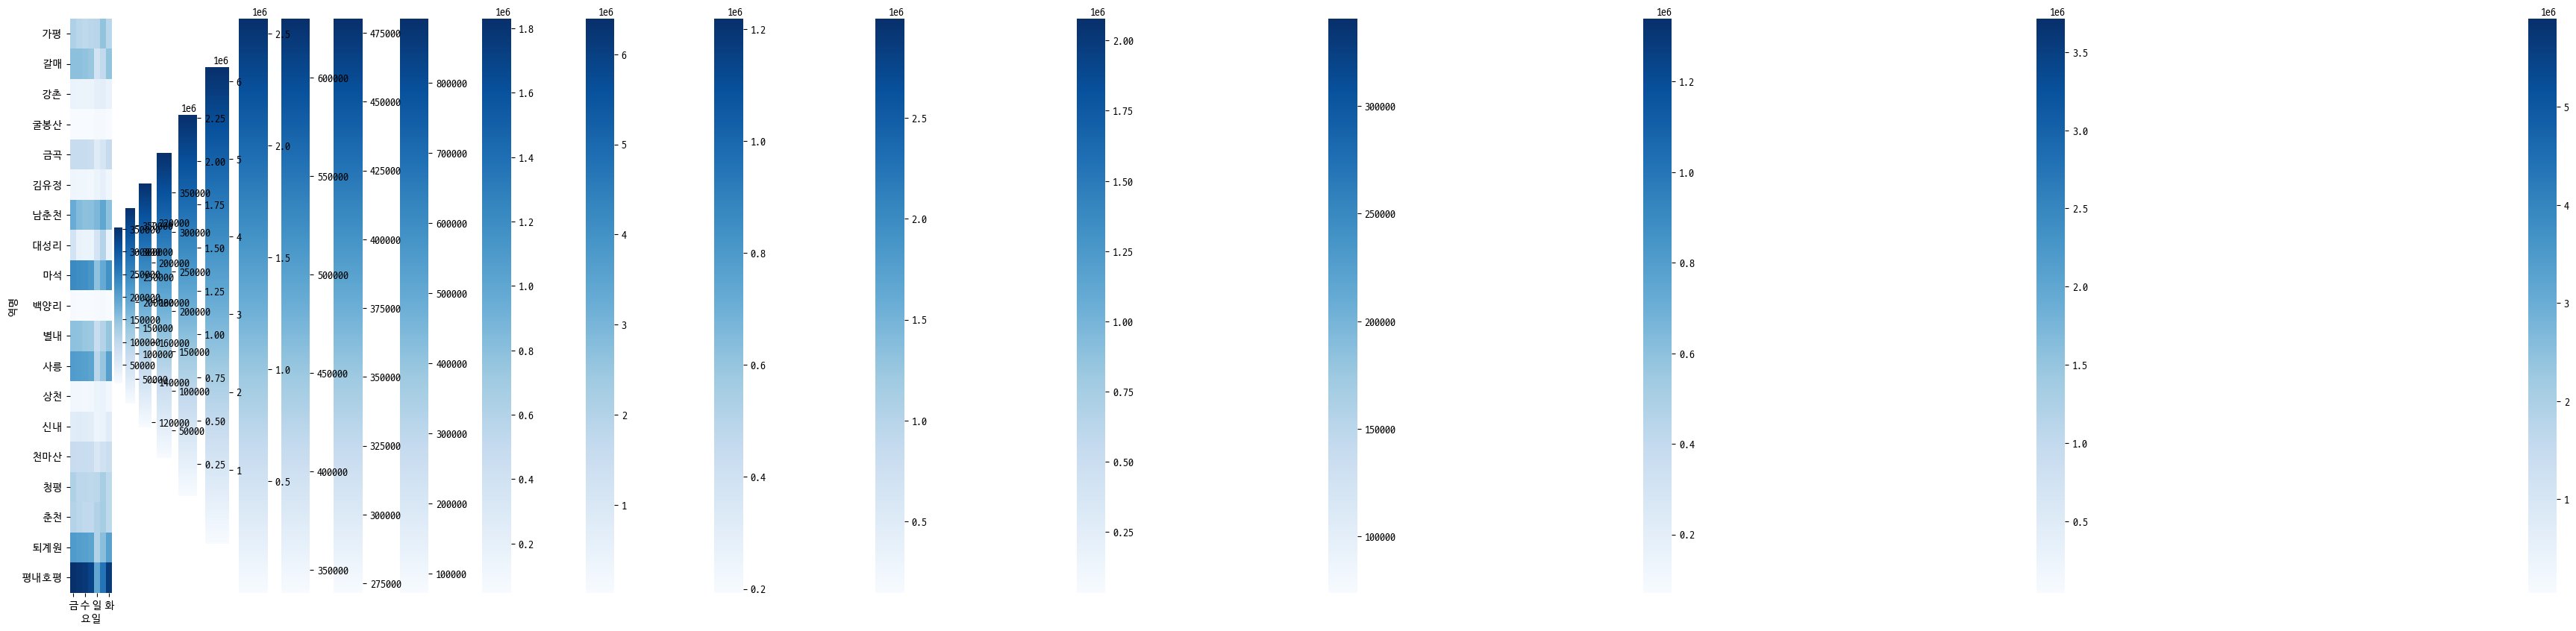

In [30]:
n_lines = len(df_subway_raw['노선명'].unique())

SIZE = 5

W = 10
H = math.ceil(n_lines / W)

plt.figure(figsize=(SIZE*W, SIZE*H))

for line_no, line in enumerate(df_subway_raw['노선명'].unique()):
    df = df_subway_raw[df_subway_raw['노선명'] == line] \
        .groupby(['역명', '요일']) \
        .sum('승하차총승객수') \
        .reset_index() \
        .pivot(index='역명', columns='요일', values='승하차총승객수')

    sns.heatmap(data=df, fmt=',.0f', cmap='Blues')

plt.show()

### 7. 1호선에서 가장 하차를 많이 하는 역은? (groupby)

,역명,승차총승객수,하차총승객수,등록일자,주차,연,월,승하차총승객수
1,가산디지털단지,"10,111,317.0","10,571,381.0",7308916248,4912,730878,1270,20682698


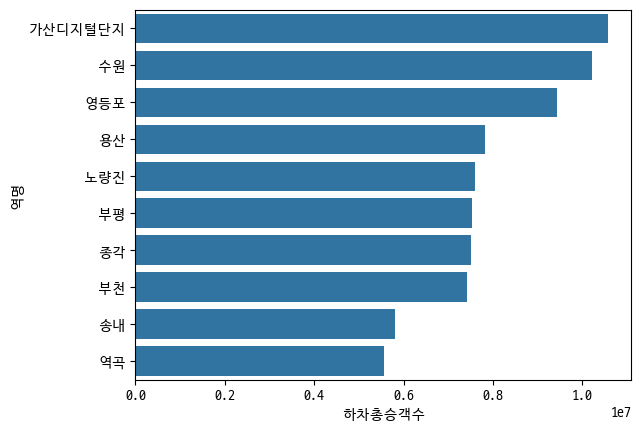

In [31]:
df = df_subway_raw[df_subway_raw['노선명'] == '1호선'] \
    .groupby('역명') \
    .sum('하차총승객수') \
    .reset_index() \
    .sort_values(by='하차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='하차총승객수', y='역명')

df.head(1)

### 8. 2호선 중에서 어느 역에서 승차가 가장 많이 발생할까? (Folium 역 표시)

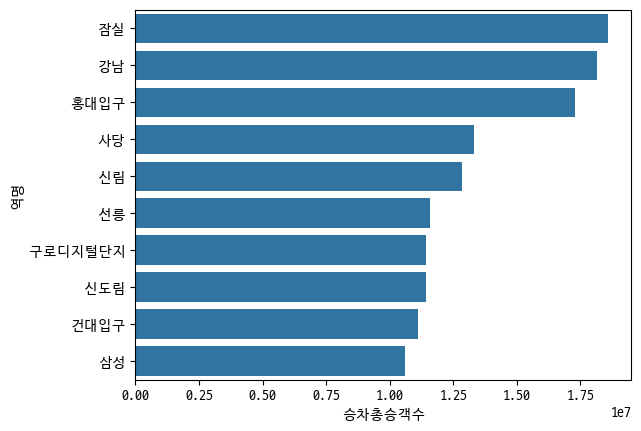

In [32]:
df = df_subway_raw[df_subway_raw['노선명'] == '2호선'] \
    .groupby('역명') \
    .sum('승차총승객수') \
    .reset_index() \
    .sort_values(by='승차총승객수', ascending=False)

sns.barplot(data=df.head(10), x='승차총승객수', y='역명')

target_station = df.iloc[0]['역명']

In [33]:
df_location_raw = pd.read_csv(str(BASE_DIR / '실습' / 'rawfiles' / '지하철노선위경도정보2.csv'))
df_location_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   역이름     975 non-null    object 
 1   역지역     975 non-null    object 
 2   위도      975 non-null    float64
 3   경도      975 non-null    float64
 4   호선      975 non-null    object 
dtypes: float64(2), object(3)
memory usage: 38.2+ KB


In [34]:
df = df_location_raw[df_location_raw['호선'] == '2호선']
df.head()

,역이름,역지역,위도,경도,호선
0,낙성대,수도권,37.47708963,126.9635058,2호선
2,서울대입구,수도권,37.4812845,126.9526951,2호선
7,강변,수도권,37.53511805,127.094723,2호선
8,영등포구청,수도권,37.52583052,126.8966683,2호선
10,잠실새내,수도권,37.51160835,127.0863007,2호선


In [35]:
df = df[df['역이름'] == target_station]

latitudes, longtitudes = df['위도'].values, df['경도'].values

folium_map = folium.Map(location=[latitudes, longtitudes], zoom_start=15)
folium.Marker([latitudes, longtitudes], popup=target_station).add_to(folium_map)

folium_map  # prints the map

In [23]:
df_population_raw = pd.read_csv(str(BASE_DIR / 'data' / '등록인구_2019.csv'))
df_population_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시점      1248 non-null   object 
 1   동별(1)   1248 non-null   object 
 2   동별(2)   1248 non-null   object 
 3   구분별(1)  1248 non-null   object 
 4   구분별(2)  1248 non-null   object 
 5   데이터     1248 non-null   float64
dtypes: float64(1), object(5)
memory usage: 58.6+ KB


In [24]:
df_population_raw

,시점,동별(1),동별(2),구분별(1),구분별(2),데이터
0,2019 1/4,합계,소계,세대 (세대),소계,"4,290,922.0"
1,2019 1/4,합계,소계,계 (명),소계,"10,054,979.0"
2,2019 1/4,합계,소계,계 (명),남자,"4,909,387.0"
3,2019 1/4,합계,소계,계 (명),여자,"5,145,592.0"
4,2019 1/4,합계,소계,한국인 (명),소계,"9,770,216.0"
...,...,...,...,...,...,...
1243,2019 4/4,합계,강동구,등록외국인 (명),소계,"4,323.0"
1244,2019 4/4,합계,강동구,등록외국인 (명),남자,"2,003.0"
1245,2019 4/4,합계,강동구,등록외국인 (명),여자,"2,320.0"
1246,2019 4/4,합계,강동구,세대당인구 (명),소계,2.38


In [33]:
df = df_population_raw.copy()
df = df[df['동별(2)'] != '소계']
df = df[df['구분별(1)'] == '계 (명)']
df = df[df['구분별(2)'] == '소계']

df['인구수'] = df['데이터'].astype(int)
df['동'] = df['동별(2)']
df['연월일'] = pd.to_datetime(df['시점'], format='%Y %m/%d')
df['월'] = df['연월일'].dt.month

df = df[['연월일', '동', '인구수']]
df

,연월일,동,인구수
13,2019-01-04,종로구,162913
25,2019-01-04,중구,135836
37,2019-01-04,용산구,245139
49,2019-01-04,성동구,314608
61,2019-01-04,광진구,370658
...,...,...,...
1189,2019-04-04,관악구,517334
1201,2019-04-04,서초구,435107
1213,2019-04-04,강남구,550209
1225,2019-04-04,송파구,682741
